In [4]:
# coding: utf-8
import sys
sys.path.append('..')
import os
import numpy as np

In [5]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [9]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [10]:
# corpus 语料词汇id，来源自preprocess()
# vocab_size 词汇个数
# window_size 取当前单词前后多大窗口的单词
# return: 共现矩阵
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - 1  # 当前单词左边单词idx
            right_idx = idx + 1 # 当前单词右边单词idx
            
            # 如果当前单词左边存在相邻单词
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            # 如果当前单词右边存在相邻单词    
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [12]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
co_matrix = create_co_matrix(corpus, 7)
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


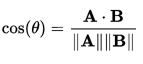

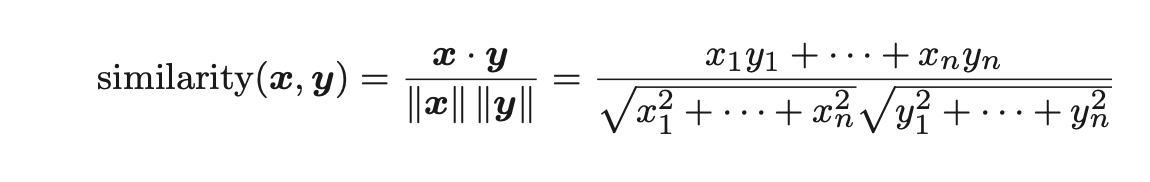

In [16]:
# 余弦相似度： 两向量点积 / 两向量L2范数的积    [-1, 1]
# eps: 微小值，防止零向量除零错误
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx, ny)

In [17]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) 
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # you的单词向量
c1 = C[word_to_id['i']]   # i的单词向量 
print(cos_similarity(c0, c1))

0.7071067691154799


In [18]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    if query not in word_to_id: 
        print('%s is not found' % query) 
        return
    
    # 获取查询的单词向量
    print('\n[query] ' + query) 
    query_id = word_to_id[query] 
    query_vec = word_matrix[query_id]
    
    # 获取语料中每个单词与当前查询词的余弦相似度
    vocab_size = len(id_to_word) 
    similarity = np.zeros(vocab_size) 
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    count = 0
    # -1 * similarity 表示降序
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query: 
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        # 打印 top x
        count += 1
        if count >= top:
            return

In [20]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) 
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
most_similar('you', word_to_id, id_to_word, C, top=5)
# 语料库太小，导致 hello、goodbye和you的余弦相似度也很高


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## PMI (pointwise mutual information)
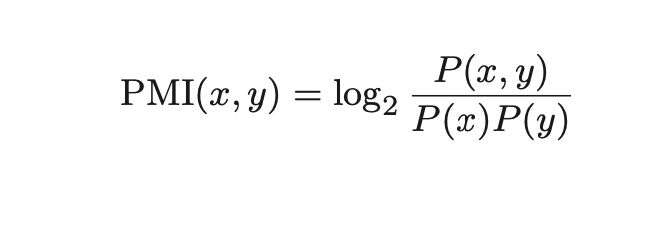
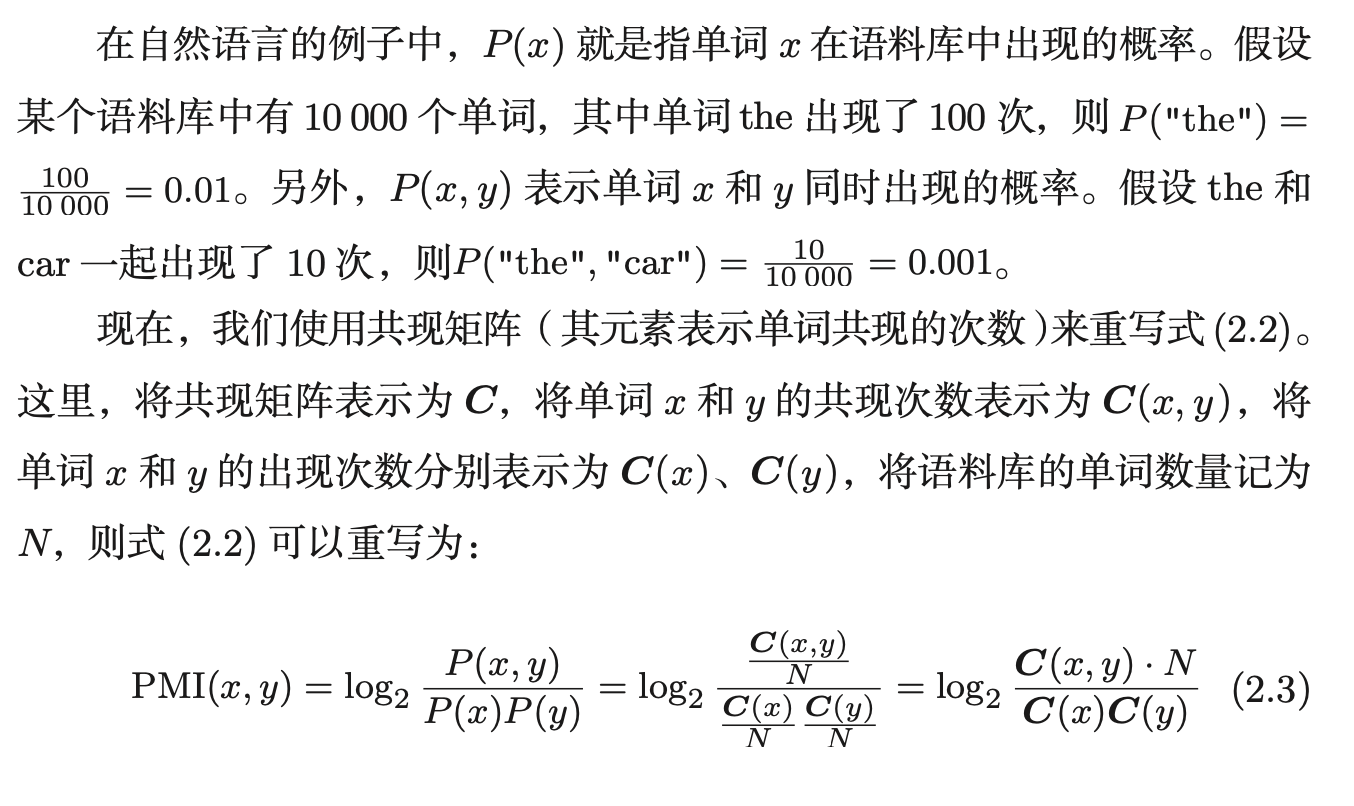
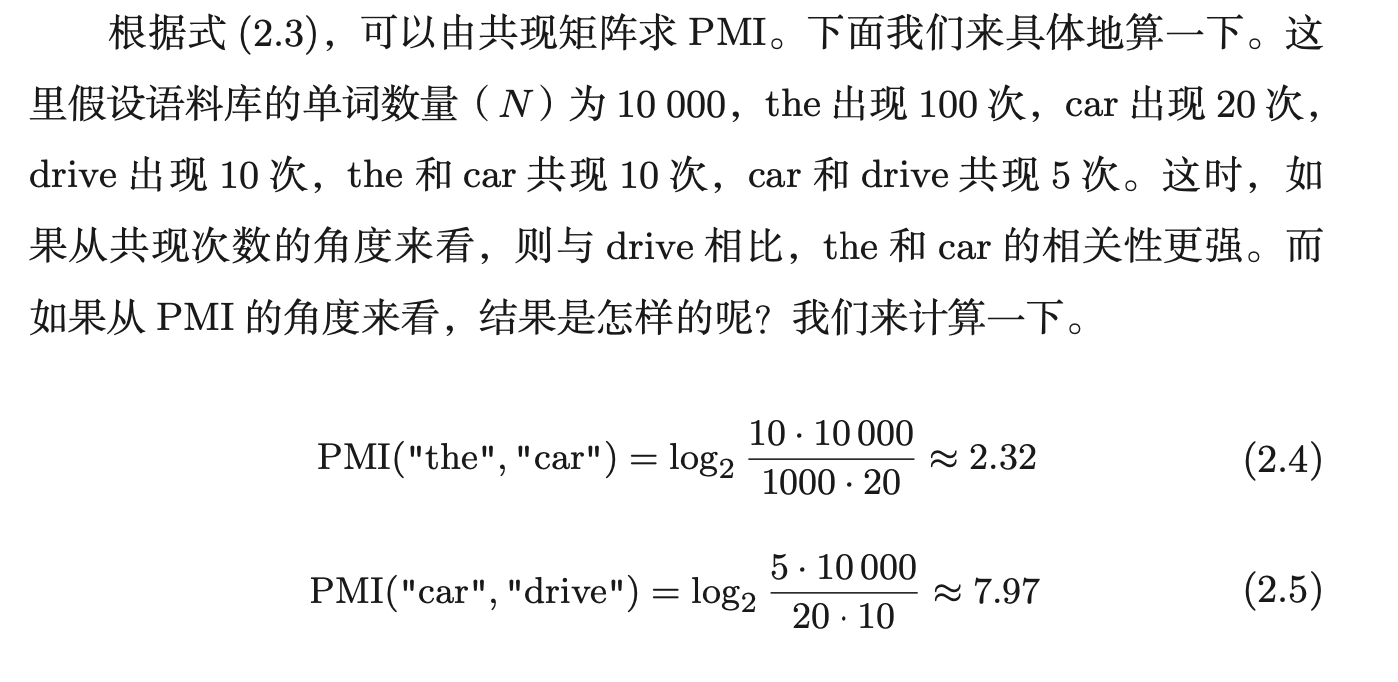

## PPMI (positive pointwise mutual information) 
解决 log20 = −∞ 问题